# **PNe fitting analysis**

In [361]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii, fits
from matplotlib.patches import Rectangle, Ellipse, Circle
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
from MUSE_Models import MUSE_3D_residual, PNe_spectrum_extractor, PSF_residuals, data_cube_y_x
import pdb

# Load in yaml file to query galaxy properties
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data)

region = ["center","halo"]    
    
# Queries user for a galaxy name, in the form of FCC000, and taking the relevant info from the yaml file
choose_galaxy = input("Please type which Galaxy you want to analyse, use FCC000 format: ")
galaxy_data = galaxy_info[choose_galaxy]

In [362]:
def open_data(choose_galaxy,region):
    # Load in the residual data, in list form
    hdulist = fits.open(choose_galaxy+"_data/"+region+"/"+choose_galaxy+"_residuals_list.fits") # Path to data
    res_hdr = hdulist[0].header # extract header from residual cube

    # Check to see if the wavelength is in the fits fileby checking length of fits file.
    if len(hdulist) == 2: # check to see if HDU data has 2 units (data, wavelength)
        wavelength = np.exp(hdulist[1].data)
    else:
        wavelength = np.load(galaxy_data["wavelength"])

    # Use the length of the data to return the size of the y and x dimensions of the spatial extent.
    if (choose_galaxy == 'FCC153') & (region == "center"):
        y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
    elif (choose_galaxy != 'FCC153') & (region == "center"):
        x_data, y_data, n_data = data_cube_y_x(len(hdulist[0].data))
    if (choose_galaxy == 'FCC153') & (region == "halo"):
        x_data, y_data, n_data = data_cube_y_x(len(hdulist[0].data))
    elif (choose_galaxy != 'FCC153') & (region == "halo"):
        y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
        
    return x_data, y_data, hdulist, wavelength

In [363]:
def fitting_analysis(galaxy_info, galaxy_data, choose_galaxy, region, fit_1D='Y'):
    # Load in the residual data, in list form
    x_data, y_data, hdulist, wavelength = open_data(choose_galaxy, region)

    # Indexes where there is spectral data to fit. We check where there is data that doesn't start with 0.0 (spectral data should never be 0.0).
    non_zero_index = np.squeeze(np.where(hdulist[0].data[:,0] != 0.))

    # Constants
    n_pixels= 9 # number of pixels to be considered for FOV x and y range
    c = 299792458.0 # speed of light

    z = galaxy_data["z"] # Redshift - taken from simbad / NED - read in from yaml file
    D = galaxy_data["Distance"] # Distance in Mpc - from Simbad / NED - read in from yaml file

    # Construct the PNe FOV coordinate grid for use when fitting PNe.
    coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])

    # Defines spaxel by spaxel fitting model
    def spaxel_by_spaxel(params, x, data, error, spec_num):
        Amp = params["Amp"]
        wave = params["wave"]
        FWHM = params["FWHM"]
        Gauss_bkg = params["Gauss_bkg"]
        Gauss_grad = params["Gauss_grad"]

        Gauss_std = FWHM / 2.35482
        # Double peaked Gaussian model that fits the primary 5007 A and doublet 4959 A line, using redshift and known offset of lines to fit secondary peak.
        model = ((Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - wave)** 2 / Gauss_std**2.) +
                 (Amp/3.) * np.exp(- 0.5 * (x - (wave - 47.9399*(1+z)))** 2 / Gauss_std**2.))

        # Saves both the Residual noise level of the fit, alongside the 'data residual' (data-model) array from the fit.
        list_of_rN[spec_num] = np.std(data - model)
        data_residuals[spec_num] = data - model

        return (data - model) / error

    # Estimating the sigma given by pPXF
    def robust_sigma(y, zero=False):
        """
        Biweight estimate of the scale (standard deviation).
        Implements the approach described in
        "Understanding Robust and Exploratory Data Analysis"
        Hoaglin, Mosteller, Tukey ed., 1983, Chapter 12B, pg. 417

        """
        y = np.ravel(y)
        d = y if zero else y - np.median(y)

        mad = np.median(np.abs(d))
        u2 = (d/(9.0*mad))**2  # c = 9
        good = u2 < 1.0
        u1 = 1.0 - u2[good]
        num = y.size * ((d[good]*u1**2)**2).sum()
        den = (u1*(1.0 - 5.0*u2[good])).sum()
        sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference

        return sigma

    # Run Spaxel by Spaxel fit of the spectra within the .fits file.
    # Check if fit_1D parameter, within the Galaxy_info.yaml file is set to Y (yes to fit), or N (no to fit - has been fitted before).
    if fit_1D == "Y":
        # Run Spaxel by Spaxel fitter
        print("Fitting Galaxy Spaxel by Spaxel, for [OIII] doublet")

        list_of_std = np.abs(np.std(hdulist[0].data ,1))
        input_errors = [np.repeat(item, len(wavelength)) for item in list_of_std] # Intially use the standard deviation of each spectra as the uncertainty for the spaxel fitter.

        # Setup numpy arrays for storage of best fit values.
        best_fit_A = np.zeros((len(hdulist[0].data),2))
        list_of_rN = np.zeros(len(hdulist[0].data))
        data_residuals = np.zeros((len(hdulist[0].data),len(wavelength)))
        obj_residuals = np.zeros((len(hdulist[0].data),len(wavelength)))

        # setup LMfit paramterts
        params = Parameters()
        params.add("Amp",value=70., min=0.001)
        params.add("wave", value=5007.0*(1+z),
                   min=5007.0*(1+z)-40,
                   max=5007.0*(1+z)+40) # wavelength (mean) starts at redshift informed position, transforming 5007 to the expected value. set to a range of 40 A around starting position.
        params.add("FWHM", value=2.81, vary=False) # Line Spread Function
        params.add("Gauss_bkg", value=0.001)
        params.add("Gauss_grad", value=0.001)

        for i in non_zero_index:
            fit_results = minimize(spaxel_by_spaxel, params, args=(wavelength, hdulist[0].data[i], input_errors[i], i), nan_policy="propagate")
            best_fit_A[i] = [fit_results.params["Amp"], fit_results.params["Amp"].stderr]
            obj_residuals[i] = fit_results.residual

        gauss_A = [A[0] for A in best_fit_A]
        A_err = [A[1] for A in best_fit_A]
        A_rN = np.array([A / rN for A,rN in zip(gauss_A, list_of_rN)])
        Gauss_F = np.array(gauss_A) * np.sqrt(2*np.pi) * 1.19

        # Save A/rN, Gauss A, Guass F and rN arrays as npy files.
        np.save("exported_data/"+ galaxy_data["Galaxy name"] +"/"+region+"/A_rN_cen", A_rN)
        np.save("exported_data/"+ galaxy_data["Galaxy name"] +"/"+region+"/gauss_A_cen", gauss_A)
        np.save("exported_data/"+ galaxy_data["Galaxy name"] +"/"+region+"/gauss_A_err_cen", A_err)
        np.save("exported_data/"+ galaxy_data["Galaxy name"] +"/"+region+"/gauss_F_cen", Gauss_F)
        np.save("exported_data/"+ galaxy_data["Galaxy name"] +"/"+region+"/rN", list_of_rN)

        # save the data and obj res in fits file format to us memmapping.
        hdu_data_res = fits.PrimaryHDU(data_residuals)
        hdu_obj_res = fits.PrimaryHDU(obj_residuals)
        hdu_data_res.writeto("exported_data/"+ galaxy_data["Galaxy name"] +"/"+region+"/resids_data.fits", overwrite=True)
        hdu_obj_res.writeto("exported_data/"+ galaxy_data["Galaxy name"] +"/"+region+"/resids_obj.fits", overwrite=True)

        print("Cube fitted, data saved.")

        # Construct A/rN, A_5007 and F_5007 plots, and save in Plots/Galaxy_name/
        # Plot A/rN
        plt.figure(figsize=(20,20))
        plt.imshow(np.array(A_rN).reshape(y_data, x_data), origin="lower", cmap="CMRmap", vmin=2, vmax=8)
        plt.colorbar()
        plt.savefig("Plots/"+ galaxy_data["Galaxy name"]+"/"+region+"/A_rN_map.png")
        plt.close()

        # Plot A_5007
        plt.figure(figsize=(20,20))
        plt.imshow(np.array(gauss_A).reshape(y_data, x_data), origin="lower", cmap="CMRmap", vmin=10, vmax=80)
        plt.colorbar()
        plt.savefig("Plots/"+ galaxy_data["Galaxy name"]+"/"+region+"/A_5007_map.png")
        plt.close()

        # Plot F_5007
        plt.figure(figsize=(20,20))
        plt.imshow(np.array(Gauss_F).reshape(y_data, x_data), origin="lower", cmap="CMRmap", vmin=10, vmax=100)
        plt.colorbar()
        plt.savefig("Plots/"+ galaxy_data["Galaxy name"]+"/"+region+"/F_5007_map.png")
        plt.close()

        print("Plots saved in Plots/"+galaxy_data["Galaxy name"])

        galaxy_info[galaxy_data["Galaxy name"]]["fit_1D"] = "N"

        with open("galaxy_info.yaml", "w") as yaml_data:
            yaml.dump(galaxy_info, yaml_data)

        # DETECT PNE here?

    # If spaxel-by-spaxel fit has already been carried out, then fit_1D will be N, proceed to 3D fit. (should check if 3D fit needed)
    elif fit_1D == "N":
        print("Cube fitted for 1D.")

    # Check is user wants to run the rest of the script, i.e. 3D model and PSF analysis
    fit_3D = input("Do you wish to continue and fit the detected [OIII] sources in 3D + PSF analysis?(y/n) ")
    if fit_3D == "y":

        print("Starting PNe analysis with initial PSF guess")
        # load from saved files

        # Read in list of x and y coordinates of detected sources for 3D fitting.
        x_y_list = np.load("exported_data/"+ galaxy_data["Galaxy name"] +"/" +region+"/pne_x_y_list.npy")
        x_PNe = np.array([x[0] for x in x_y_list]) # separate out from the list the list of x coordinates, as well as y coordinates.
        y_PNe = np.array([y[1] for y in x_y_list])
        
        # Retrieve the respective spectra for each PNe source, from the list of spectra data file, using a function to find the associated index locations of the spectra for a PNe.
        PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

        # create Pandas dataframe for storage of values from the 3D fitter.
        PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "[OIII] Flux", "Flux error","[OIII]/Hb","Ha Flux", "V (km/s)", "m 5007", "M 5007", "M 5007 error", "A/rN", "redchi"))
        PNe_df["PNe number"] = np.arange(1,len(x_PNe)+1)
        
        # Read in Objective Residual Cube .fits file.
        obj_residual_cube = fits.open("exported_data/"+ galaxy_data["Galaxy name"] +"/"+region+"/resids_obj.fits")

        # Read in Data Residual Cube .fits file.
        data_residual_cube = fits.open("exported_data/"+ galaxy_data["Galaxy name"] +"/"+region+"/resids_data.fits")

        # Function to extract the uncertainties and transform them into a standard deviation version for fitting purposes.
        def uncertainty_cube_construct(data, x_P, y_P, n_pix):
            data[data == np.inf] = 0.01
            extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
            array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
            for p in np.arange(0, len(x_P)):
                list_of_std = np.abs(np.std(extract_data[p], 1))
                array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]

            return array_to_fill

        # Run above function to get the error and obj_error cubes for fitting purposes (uncertainty).
        error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
        obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

        print("Files loaded.")


        # This is the start of the setup for the 3D fitter.
        # Initialise the paramters for 3D fitting.
        PNe_multi_params = Parameters()

        # extract dictionary of emissions from Galaxy_info.yaml file.
        emission_dict = galaxy_data["emissions"]

        # Function to generate the parameters for the 3D model and fitter. Built to be able to handle a primary emission ([OIII] here).
        # Buil to fit for other emissions lines, as many as are resent in the emission dictionary.
        def gen_params(wave=5007*(1+z), FWHM=4.0, beta=2.5, em_dict=None):
            # loop through emission dictionary to add different element parameters
            for em in em_dict:
                # Amplitude parameter for each emission
                PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.01, expr=emission_dict[em][1])
                # Wavelength parameter for each emission
                if emission_dict[em][2] == None:
                    PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-40., max=wave+40.)
                else:
                    PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))

            # Add the rest of the paramters for the 3D fitter here, including the PSF (Moffat FWHM (M_FWHM) and beta)
            PNe_multi_params.add('x_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
            PNe_multi_params.add('y_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
            PNe_multi_params.add("M_FWHM", value=FWHM, vary=False)
            PNe_multi_params.add("beta", value=beta, vary=False)
            PNe_multi_params.add("Gauss_bkg",  value=0.00001)
            PNe_multi_params.add("Gauss_grad", value=0.00001)

        # generate default parameters using above function.
        gen_params(em_dict=emission_dict)

        # Setup Numpy arrays for storing values from the fitter
        total_Flux = np.zeros((len(x_PNe), len(emission_dict)))                         # Total integrated flux of each emission, as measured for the PNe.
        A_2D_list = np.zeros((len(x_PNe), len(emission_dict)))                          # Amplitude from the Moffat function
        F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))     # Array of flux arrays for each emission.
        emission_amp_list = np.zeros((len(x_PNe), len(emission_dict)))                  # List of each emission's amplitude
        model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength))) # Array of the model spectral fits
        mean_wave_list = np.zeros((len(x_PNe), len(emission_dict)))                     # List of the measured wavelength positions for each emission
        residuals_list = np.zeros(len(x_PNe))                                           # List of the residual noise level of each fit.
        list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength))) # List of arrays of best fit residuals (data-model)
        chi_2_r = np.zeros((len(x_PNe)))

        # Setup Numpy arrays for storing the errors from the fitter.
        moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
        x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
        y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
        mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
        Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
        Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

        # Setup Numpy arrays for storing the other best fit values from the 3D fitter.
        FWHM_list = np.zeros(len(x_PNe))
        list_of_x = np.zeros(len(x_PNe))
        list_of_y = np.zeros(len(x_PNe))
        Gauss_bkg = np.zeros(len(x_PNe))
        Gauss_grad = np.zeros(len(x_PNe))


        # Define a function that contains all the steps needed for fitting, including the storage of important values, calculations and pandas assignment.
        def run_minimiser(parameters):
            for PNe_num in np.arange(0, len(x_PNe)):
                useful_stuff = [] # Used to store other outputs from the 3D model function: maximum spectral amplitude, flux arrays for each emission, A_xy, model spectra
                #run minimizer fitting routine
                multi_fit_results = minimize(MUSE_3D_residual, PNe_multi_params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
                total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
                list_of_fit_residuals[PNe_num] = useful_stuff[0]
                A_2D_list[PNe_num] = useful_stuff[1][0]
                F_xy_list[PNe_num] = useful_stuff[1][1]
                model_spectra_list[PNe_num] = useful_stuff[1][3]
                emission_amp_list[PNe_num] = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
                mean_wave_list[PNe_num] = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]
                chi_2_r[PNe_num] = multi_fit_results.redchi
                list_of_x[PNe_num] = multi_fit_results.params["x_0"]
                list_of_y[PNe_num] = multi_fit_results.params["y_0"]
                Gauss_bkg[PNe_num] = multi_fit_results.params["Gauss_bkg"]
                Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
                #save errors
                moff_A_err[PNe_num] = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
                mean_wave_err[PNe_num] = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]
                x_0_err[PNe_num] = multi_fit_results.params["x_0"].stderr
                y_0_err[PNe_num] = multi_fit_results.params["y_0"].stderr
                Gauss_bkg_err[PNe_num] = multi_fit_results.params["Gauss_bkg"].stderr
                Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

            # Amplitude / residul Noise calculation
            list_of_rN = np.array([np.std(PNe_res) for PNe_res in list_of_fit_residuals])
            PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude

            # de-redshift the fitted wavelengths to get the velocity
            de_z_means = mean_wave_list[:,0] / (1 + z)

            PNe_df["V (km/s)"] = (c * (de_z_means - 5007.) / 5007.) / 1000.

            PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total [OIII] 5007A emission line flux

            PNe_df["A_OIII"] = A_2D_list[:,0]

            #PNe_df["Ha Flux"] = total_Flux[:, 2] # store total Ha flux.

            #PNe_df["[OIII]/Ha"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Ha ratio

            #PNe_df["Hb Flux"] = total_Flux[:, 3] # store total Hb flux.

            #PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,3] # store [OIII]/Hb ratio

            #PNe_df["[NII]/Ha"] = total_Flux[:,4] / total_Flux[:,2] # store [NII]/Ha ratio

            PNe_df["redchi"] = chi_2_r

            # This is used by Pandas to calculate the Absolute Magnitude of each PNe
            def log_10(x):
                return np.log10(x)

            # Calculate the apparent and Absolute Magnitudes for each PNe
            PNe_df["m 5007"] = -2.5 * PNe_df["[OIII] Flux"].apply(log_10) - 13.74       # Apparent Magnitude
            dM =  5. * np.log10(D) + 25.                                                # Distance modulus
            PNe_df["M 5007"] = PNe_df["m 5007"] - dM                                    # Absolute Magnitude

            # Use the brightest PNe in m_5007 to estimate the Distance.
            Dist_est = 10.**(((PNe_df["m 5007"].min() + 4.5) -25.) / 5.)
            print("Distance Estimate from PNLF: ", Dist_est, "Mpc")

            # Construct a Astropy table to save certain values for each galaxy.
            PNe_table = Table([np.arange(0,len(x_PNe)), np.round(x_PNe), np.round(y_PNe),
                               PNe_df["[OIII] Flux"].round(20),
                               PNe_df["m 5007"].round(2),
                               PNe_df["M 5007"].round(2),
                               PNe_df["redchi"],
                               PNe_df["A/rN"],
                               PNe_df["A_OIII"]],
                              names=("PNe number", "x", "y", "[OIII] Flux", "m 5007", "M 5007", "Chisqr", "A_rN", "A_OIII"))
            ascii.write(PNe_table, galaxy_data['Galaxy name']+'_data/'+region+'/'+"{}_table.txt".format(galaxy_data["Galaxy name"]), format="tab", overwrite=True)
            ascii.write(PNe_table, galaxy_data['Galaxy name']+'_data/'+region+'/'+"{}_PNe_table_latex.txt".format(galaxy_data["Galaxy name"]), format="latex", overwrite=True)
            '''PNe_table = Table([np.arange(0,len(x_PNe)), np.round(x_PNe), np.round(y_PNe),
                               PNe_df["[OIII] Flux"].round(20),
                               PNe_df["[OIII]/Hb"].round(2),
                               PNe_df["[OIII]/Ha"].round(2),
                               PNe_df["[NII]/Ha"].round(2),
                               PNe_df["m 5007"].round(2),
                               PNe_df["M 5007"].round(2),
                               PNe_df["redchi"],
                               PNe_df["A/rN"]],
                              names=("PNe number", "x", "y", "[OIII] Flux", "[OIII]/Hb", "[OIII]/Ha", "[NII]/Ha", "m 5007", "M 5007", "Chisqr", "A_rN"))
            ascii.write(PNe_table, galaxy_data['Galaxy name']+'_data/'+"{}_table.txt".format(galaxy_data["Galaxy name"]), format="tab", overwrite=True)
            ascii.write(PNe_table, galaxy_data['Galaxy name']+'_data/'+"{}_PNe_table_latex.txt".format(galaxy_data["Galaxy name"]), format="latex", overwrite=True)'''
            print(galaxy_data["Galaxy name"]+ "_table.txt saved")
            print(galaxy_data["Galaxy name"]+ "_PNe_table_latex.txt saved")

        print("Running fitter")
        run_minimiser(PNe_multi_params) # Run the 3D model fitter.

        # Plot and save the histogram of m_5007
        plt.figure( figsize=(12,10))
        bins, bins_cens, other = plt.hist(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=10, edgecolor="black", linewidth=0.8, label="m 5007 > 2 * A/rN", alpha=0.5)
        plt.xlim(26.0,30.0)
        plt.xlabel("$m_{5007}$", fontsize=24)
        plt.ylabel("N Sources/bin", fontsize=24)
        plt.legend(fontsize=15)
        plt.savefig("Plots/"+ galaxy_data["Galaxy name"]+"/m_5007_histogram.png")
        plt.close()
        #bins_cens = bins_cens[:-1]

        # Here we start the PSF analysis
        # First ask which to attempt: brightest or pre-selected PNe
        # if brightest, then ask how many PNe to use from a list of the brightest in m_5007
        # if pre-selected, then ask for which PNe numbers to use.
        use_brightest = input("Use Brightest PNe? (y/n) ")
        if use_brightest == "y":
            how_many = input("How many brightest PNe would you like to fit for the PSF? Please enter a number greater than 0: ")
            sel_PNe = PNe_df.nsmallest(int(how_many), "m 5007").index.values # query the PNe dataframe for the n brightest PNe in m_5007.
        elif use_brightest == "n":
            which_PNe = input("Which PNe would you like to use for PSF analysis? Please enter numbers, separated by spaces: ")
            # Devise system for PNe choise based upon low background (radial?)
            sel_PNe = [int(i) for i in which_PNe.split()]

        print(sel_PNe)

        selected_PNe = PNe_spectra[sel_PNe] # Select PNe from the PNe minicubes
        selected_PNe_err = obj_error_cube[sel_PNe] # Select associated errors from the objective error cubes

        PSF_params = Parameters()

        def model_params(p, n, amp, wave):
            PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
            PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
            PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
            PSF_params.add("wave_{:03d}".format(n), value=wave, min=wave-40., max=wave+40.)
            PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
            PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001)

        for i in np.arange(0,len(sel_PNe)):
                model_params(p=PSF_params, n=i, amp=200.0, wave=5007*(1+z))

        PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
        PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True)

        print("Fitting for PSF")
        PSF_results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

        #determine PSF values and feed back into 3D fitter

        fitted_FWHM = PSF_results.params["FWHM"].value
        fitted_beta = PSF_results.params["beta"].value

        #Fit PNe with updated PSF
        gen_params(FWHM=fitted_FWHM, beta=fitted_beta, em_dict=emission_dict) # set params up with fitted FWHM and beta values
        print("Fitting with PSF")
        run_minimiser(PNe_multi_params) # run fitting section again with new values

        # Plot out each full spectrum with fitted peaks
        for o in np.arange(0, len(x_PNe)):
            plt.figure(figsize=(30,10))
            plt.plot(wavelength, np.sum(PNe_spectra[o],0), alpha=0.7, c="k") # data
            plt.plot(wavelength, np.sum(model_spectra_list[o],0), c="r") # model
            plt.axhline(residuals_list[o], c="b", alpha=0.6)
            plt.xlabel("Wavelength ($\AA$)", fontsize=18)
            plt.ylabel("Flux Density ($10^{-20}$ $erg s^{-1}$ $cm^{-2}$ $\AA^{-1}$ $arcsec^{-2}$)", fontsize=18)
            plt.ylim(-100,2000)
            plt.savefig("Plots/"+ galaxy_data["Galaxy name"] +"/"+region+"/full_spec_fits/PNe_{}".format(o))
            plt.close()
            plt.clf()

        #Run the rest of the analysis

        print("PNe analysis complete.")

    elif fit_3D == "n":
        print("Exiting PNe fitting script.")
        
    return [PNe_df,x_data,y_data,PNe_multi_params]

Running the analysis for both pointings:

In [ ]:
data_cen = fitting_analysis(galaxy_info, galaxy_data, choose_galaxy, "center",fit_1D='Y')
data_hal = fitting_analysis(galaxy_info, galaxy_data, choose_galaxy, "halo",fit_1D='Y')

Fitting Galaxy Spaxel by Spaxel, for [OIII] doublet
Cube fitted, data saved.
Plots saved in Plots/FCC170


## **Results splitter**

In [305]:
# Split the results between center and halo pointings
PNe_df_cen,x_data_cen,y_data_cen,PNe_multi_params_cen = data_cen[0],data_cen[1],data_cen[2],data_cen[3]
PNe_df_hal,x_data_hal,y_data_hal,PNe_multi_params_hal = data_hal[0],data_hal[1],data_hal[2],data_hal[3]

# Getting magnitudes
mag_cen, mag_hal = PNe_df_cen["M 5007"].loc[PNe_df_cen["A/rN"] > 2.0], PNe_df_hal["M 5007"].loc[PNe_df_hal["A/rN"] > 2.0]

# Combining the magnitudes for both components
mag = []
mag.extend(mag_cen)
mag.extend(mag_hal)
mag = np.array(mag)

We need to get the PNe coordinates in order to place the both pointings in the galaxy centre frame. Once we have changed the coordinates, we just need to rotate and split considering and aperture of different dimensions in function of the selected galaxy.

In [352]:
# Extracting the coordinates and constraining to A/rN > 2.0
x_cen, y_cen = np.load("exported_data/"+choose_galaxy+"/center/pne_x_y_list.npy")[:,0],np.load("exported_data/"+choose_galaxy+"/center/pne_x_y_list.npy")[:,1]
x_hal, y_hal = np.load("exported_data/"+choose_galaxy+"/halo/pne_x_y_list.npy")[:,0],np.load("exported_data/"+choose_galaxy+"/halo/pne_x_y_list.npy")[:,1]

x_cen, y_cen = x_cen[np.where(PNe_df_cen["A/rN"] > 2.0)[0]], y_cen[np.where(PNe_df_cen["A/rN"] > 2.0)[0]]
x_hal, y_hal = x_hal[np.where(PNe_df_hal["A/rN"] > 2.0)[0]], y_hal[np.where(PNe_df_hal["A/rN"] > 2.0)[0]]

# Rescaling the coordinates with respect to the center of the galaxy:
if choose_galaxy == "FCC153":
    xc, yc   = 198.0, 223.0 # Center of the galaxy in central pointing
    xo, yo   = 452.0, 205.0
    alpha    = 97.2 # Angle to put the galaxy in vertical position
    aperture = 5.0 # Aperture to split between disk and non-disk
    amp      = [2.0, 15.0] # Amplitude of the LF for both regions
    
if choose_galaxy == "FCC170":
    xc, yc   = 131.7, 119.8 # Center of the galaxy in central pointing
    xo, yo   = 333.9, 329.8
    alpha    = -317.0 # Angle to put the galaxy in vertical position
    aperture = 14.0 # Aperture to split between disk and non-disk
    amp      = [2.0, 15.0] # Amplitude of the LF for both regions

if choose_galaxy == "FCC177":
    xc, yc   = 211.0, 199.0 # Center of the galaxy in central pointing
    xo, yo   = 205.53, -72.174
    alpha    = 4.09999 # Angle to put the galaxy in vertical position
    aperture = 6.0 # Aperture to split between disk and non-disk
    amp      = [2.0, 15.0] # Amplitude of the LF for both regions

# Convert the pixels to arcseconds and change the reference to the centre of the galaxy
x_cen, y_cen = (x_cen - xc)*0.2, (y_cen - yc)*0.2
x_hal, y_hal = (x_hal - xo)*0.2, (y_hal - yo)*0.2

# Joining coordinates for both pointings. We need to add a label in order to distinguish between center and halo pointing due
# to the difference of FWHM and beta for both pointings
xx, yy = [], []
for i in range(len(x_cen)):
    xx.append([x_cen[i],PNe_multi_params_cen['M_FWHM'].value,PNe_multi_params_cen['beta'].value,i*0+1])
    yy.append([y_cen[i],PNe_multi_params_cen['M_FWHM'].value,PNe_multi_params_cen['beta'].value,i*0+1])
for i in range(len(x_hal)):
    xx.append([x_hal[i],PNe_multi_params_hal['M_FWHM'].value,PNe_multi_params_hal['beta'].value,i*0+2])
    yy.append([y_hal[i],PNe_multi_params_hal['M_FWHM'].value,PNe_multi_params_hal['beta'].value,i*0+2])
xx = np.array(xx)
yy = np.array(yy)

In [353]:
def splitting(aperture,alpha,xx,yy,mag):
    
    ang = np.radians(alpha) # Define the angle to rotate the galaxy
    
    # Rotating the coordinates
    xcord, ycord = [], []
    for i in range(len(xx)):
        xcord.append([xx[i,0]*np.cos(ang) - yy[i,0]*np.sin(ang),xx[i,1],xx[i,2],xx[i,3]])
        ycord.append([xx[i,0]*np.sin(ang) + yy[i,0]*np.cos(ang),yy[i,1],yy[i,2],yy[i,2]])
    xcord, ycord = np.array(xcord), np.array(ycord)
    
    # Constraining the PNe within and out the selected aperture
    cond_in  = (xcord[:,0] <= aperture/2.0) & (xcord[:,0] >= -aperture/2.0)
    cond_out = (xcord[:,0] >= aperture/2.0) | (xcord[:,0] <= -aperture/2.0)
    
    x_in, y_in = xcord[cond_in,:], ycord[cond_in,:]
    mag_in     = mag[cond_in]
    
    x_out, y_out = xcord[cond_out,:], ycord[cond_out,:]
    mag_out      = mag[cond_out]
    
    return mag_in, mag_out, x_in, y_in, x_out, y_out

We need to split the magnitudes for two components: disk and non-disk

(<matplotlib.lines.Line2D at 0x1a5fbbd5f8>,
 <matplotlib.lines.Line2D at 0x1a20e324a8>)

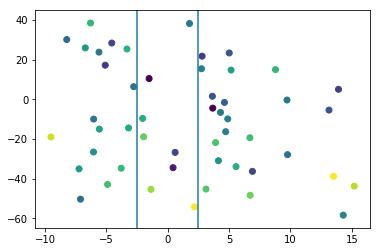

In [354]:
mag_in, mag_out, x_in, y_in, x_out, y_out = splitting(aperture,alpha,xx,yy,mag)
plt.scatter(x_in[:,0],y_in[:,0],c=mag_in); plt.scatter(x_out[:,0], y_out[:,0],c=mag_out)
plt.axvline(-aperture/2.0), plt.axvline(aperture/2.0)
plt.colorbar()

In [355]:
# Defining the FWHM and beta of both central and halo pointings respectively
FWHM_cen = np.mean(x_in[np.where(x_in[:,3] == 1)[0],1])
beta_cen = np.mean(x_in[np.where(x_in[:,3] == 1)[0],2])
FWHM_hal = np.mean(x_in[np.where(x_in[:,3] == 2)[0],1])
beta_hal = np.mean(x_in[np.where(x_in[:,3] == 2)[0],2])

# Convert to a dictionary
params = {
    
    'Center':{ 'FWHM':FWHM_cen, 'beta':beta_cen  },
    'Halo':{ 'FWHM':FWHM_hal, 'beta':beta_hal  }
    
}

In order to compute the completeness, we need to open the original cubes and get the reconstructed image to get the fraction of light with respect to the total (in percentage) which corresponds to a concrete absolute magnitude.

In [356]:
def reconstructed_image(choose_galaxy):
    hdu  = fits.open('../'+choose_galaxy+'_center.fits')
    data = hdu[1].data
    hdr  = hdu[1].header
    s    = np.shape(data)
    wave = hdr['CRVAL3']+(np.arange(s[0])-hdr['CRPIX3'])*hdr['CD3_3']

    cond = (wave >= 4900.0) & (wave <= 5100.0)
    data = np.sum(data[cond,:,:],axis=0)
    
    return data

In [357]:
image = reconstructed_image(choose_galaxy)

Estimating the distance to the galaxy taking the brightest PNe

In [358]:
D = 10.**(((PNe_df_cen["m 5007"].min() + 4.5) -25.) / 5.) # In Mpc

## **PNLF completeness estimation**

Defining the function which provides the number of bins and the flux of the noise map

In [359]:
def completeness(galaxy,mag,params,D,amp):

    n_pixels = 7
    cen_file = './exported_data/'+galaxy+'/center/resids_obj.fits'
    #hal_file = './exported_data/'+galaxy+'/halo/resids_obj.fits'
        
    x_data, y_data, hdulist, wavelength = open_data(galaxy, 'center')
    Noise_map_cen  = np.abs(np.std(hdulist[0].data, axis=1))
    Noise_map_cen  = Noise_map_cen.reshape(y_data, x_data)

    # mask out regions where sep masks
    #Y, X = np.mgrid[:y_data, :x_data]
    #xe = xc
    #ye = yc
    #length= 15
    #width = 15
    #alpha = 0.15
    #elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1

    #Noise_map_cen[elip_mask_gal == True] = 0.0
    
    #x_data, y_data = open_data(galaxy, 'halo')
    #Noise_map_hal  = np.abs(np.std(fits.open(hal_file)[0].data, axis=1))
    #Noise_map_hal  = Noise_map_hal.reshape(y_data, x_data)
    
    # Construct the PNe FOV coordinate grid for use when fitting PNe.
    coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_pixels = 7
    
    # Setup range of Absolute Magnitudes to be converted to 1D max A values

    Abs_M = np.arange(-4.5,-1.5, 0.5) #bins_cens
    dM = 5. * np.log10(D) + 25

    def moffat(amplitude, x_0, y_0, FWHM, beta):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / gamma**2
        return amplitude * (1 + rr_gg)**(-beta)

    def gaussian(x, amplitude, mean, stddev, bkg, grad):
        return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                     (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

    bins, bins_cens, other = plt.hist(mag, bins=10, edgecolor="black", linewidth=0.8, label="M 5007 > 2A/rN", alpha=0.5)

    #bins_cens = bins_cens[:-1] + dM
    bins_cens = Abs_M + dM

    #bins = bins[2:]

    #bins_cens = bins_cens[2:]

    app_m = bins_cens


    total_flux = 10**((app_m + 13.74) / -2.5) # Ciardullo's flux calibration

    flux = total_flux*1.0e20
    
    init_FWHM_cen = params['Center']['FWHM']
    init_beta_cen = params['Center']['beta']
    #init_FWHM_hal = params['Halo']['FWHM']
    #init_beta_hal = params['Halo']['beta']
    
    sum_init_cen     = np.sum(moffat(1, n_pixels/2, n_pixels/2, init_FWHM_cen, init_beta_cen))
    input_moff_A_cen = flux / sum_init_cen
    
    #sum_init_hal     = np.sum(moffat(1, n_pixels/2, n_pixels/2, init_FWHM_hal, init_beta_hal))
    #input_moff_A_hal = flux / sum_init_hal


    # Make moffat models = F_5007 (x,y)

    Moffat_models_cen = np.array([moffat(moff_A, n_pixels/2., n_pixels/2., init_FWHM_cen, init_beta_cen) for moff_A in input_moff_A_cen])
    #Moffat_models_hal = np.array([moffat(moff_A, n_pixels/2., n_pixels/2., init_FWHM_hal, init_beta_hal) for moff_A in input_moff_A_hal])
    
    # A_5007 (x,y)

    Amp_x_y_cen = ((Moffat_models_cen) / (np.sqrt(2*np.pi) * 1.19))
    max_1D_A_cen = np.array([np.max(A) for A in Amp_x_y_cen])

    #Amp_x_y_hal = ((Moffat_models_hal) / (np.sqrt(2*np.pi) * 1.19))
    #max_1D_A_hal = np.array([np.max(A) for A in Amp_x_y_hal])    
    
    N_data_cen = len(np.nonzero(Noise_map_cen)[0])
    #N_data_hal = len(np.nonzero(Noise_map_hal)[0])

    Noise_mask_cen = Noise_map_cen
    Noise_mask_plot_cen = []
    ratio_counter_cen = np.zeros(len(app_m))
    
    #fig, axs = plt.subplots(2,3, figsize=(20, 10))
    #axs = axs.ravel()
    for i,a in enumerate(max_1D_A_cen):
        Noise_mask_cen[((a / Noise_map_cen) <2.0)] = np.nan
        #axs[i].set_title("$M_{5007} = $ %s" %Abs_M[i])
        #ax = axs[i].imshow(Noise_mask_cen, origin="lower", vmin=0, vmax=30)
        
        nan_counter = np.isnan(Noise_mask_cen).sum()

        ratio_counter_cen[i] = (N_data_cen-nan_counter) / N_data_cen
        Noise_mask_plot_cen.append(Noise_mask_cen)
        
    ratio_counter = ratio_counter_cen
    
    ##############
    #    PNLF    #
    ##############

    plt.figure(1,figsize=(15,20))
    PNLF = amp * np.exp(0.307*Abs_M) * (1-np.exp(3*((-4.47 - Abs_M)))) #3000 * np.exp(-0.307*(5. * np.log10(18.7) + 25.)) *
    plt.plot(Abs_M, PNLF, 'k-', label="PNLF")
    plt.plot(Abs_M, PNLF*ratio_counter,'r-.',label=r"$PNLF_{correc}$")
    plt.xlabel(r'$M_{5007}$', fontsize=15)
    plt.ylabel(r'#', fontsize=15)
    plt.legend(fontsize=15)
    
    '''PNLF_df = pd.DataFrame(columns=("M 5007", "PNLF", "binned_values"))
    PNLF_df["M 5007"] = mag


    diff = abs(bins_cens[0]-bins_cens[1]) / 2
    bins_cens_left = bins_cens - diff
    bins_cens_right = bins_cens + diff
    PNLF_df["binned_values"] = np.digitize(PNLF_df["M 5007"], bins=bins_cens)


    def PNLF_func(params, data):

        c1 = params["c1"]
        c2 = params["c2"]

        # PNLF equation

        #PNLF = c1 * np.exp(c2*PNLF_df["M 5007"].values) * (1-np.exp(3*((PNLF_df["M 5007"].min() - PNLF_df["M 5007"].values))))
        PNLF = c1 * np.exp(c2*PNLF_df["M 5007"].values) * (1-np.exp(3*((-4.47 - mag))))
        PNLF_df["PNLF"] = PNLF

        # Binning of PNLF values
        PNLF_sum_list = np.zeros(len(bins_cens))
        for i in np.arange(1,len(bins_cens)+1):
            PNLF_sum_list[i-1] = np.median(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])

        # Scale the binned values
        return data - PNLF_sum_list


    params_PNLF = Parameters()
    params_PNLF.add("c1", value=1., vary=True)
    params_PNLF.add("c2", value=0.307, vary=True)


    results = minimize(PNLF_func, params_PNLF, args=(bins,), nan_policy="propagate")
    #plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2], edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.5)
    report_fit(results)


    ## Plotting

    plt.figure(2, figsize=(12,10))

    info = plt.hist(mag, bins=len(bins), edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.6)

    ax = plt.gca()
    #plt.xlim(26.5,29.0)
    #plt.yticks(np.arange(0,22,2), np.arange(0,22,2))
    plt.title("Apparent Magnitude Histogram", fontsize=24)
    plt.xlabel("Apparent Magnitude", fontsize=24)
    plt.ylabel("N Sources", fontsize=24)
    ax.get_yticklabels()
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=16)
    #plt.savefig("Plots/FCC167/M5007 histogram.png")


    PNLF = results.params["c1"].value*(np.exp(np.abs(results.params["c2"].value)*mag)) * (1-np.exp(3*((-4.47 - mag))))
    #PNLF = (PNLF * results.params["a"])
    #plt.scatter(PNe_df["M 5007"].loc[PNe_df["M 5007"]>-5], PNLF, c="k")


    binned_PNLF = np.zeros(len(bins_cens))
    for i in np.arange(1,len(bins_cens)+1):
        binned_PNLF[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])



    print(binned_PNLF)

    plt.plot(bins_cens_right, (binned_PNLF), color="k", label="PNLF" )
    #plt.plot(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2], PNLF, color="k", label="PNLF" )
    plt.plot(bins_cens_right, (binned_PNLF) * ratio_counter, color="r", ls="--", label=r"$PNLF_{correc}$" )
    plt.legend(fontsize=15)
    #plt.savefig("Plots/FCC167/PNLF.png")'''



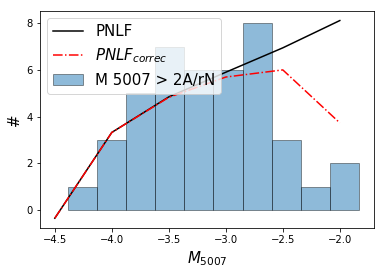

In [360]:
completeness(choose_galaxy,mag_in,params,D,amp[0]) # Estimating the completeness for the central pointing
plt.close()
completeness(choose_galaxy,mag_out,params,D,amp[1]) # Estimating the completeness for the halo pointing

Extracting the parameters from the fitting code:

In [46]:
data_cen = fits.open("exported_data/FCC153/center/resids_obj.fits")[0].data
data_hal = fits.open("exported_data/FCC153/halo/resids_obj.fits")[0].data

tab_cen, tab_hal = np.loadtxt("exported_data/FCC153/center/FCC153_table.txt"), np.loadtxt("exported_data/FCC153/halo/FCC153_table.txt") 

choose_galaxy, region = "FCC153", ["center","halo"]

Extracting the dimension of the cubes for both pointings

In [47]:
# Use the length of the data to return the size of the y and x dimensions of the spatial extent.
for i in region:
    if (choose_galaxy == 'FCC153') & (i == "center"):
        y_data_cen, x_data_cen, n_data_cen = data_cube_y_x(len(data_cen))
    elif (choose_galaxy != 'FCC153') & (i == "center"):
        x_data_cen, y_data_cen, n_data_cen = data_cube_y_x(len(data_cen))
    if (choose_galaxy == 'FCC153') & (i == "halo"):
        x_data_hal, y_data_hal, n_data_hal = data_cube_y_x(len(data_hal))
    elif (choose_galaxy != 'FCC153') & (i == "halo"):
        y_data_hal, x_data_hal, n_data_hal = data_cube_y_x(len(data_hal))

We define the absolute magnitudes and constrain them for A/rN > 2.0

In [35]:
mag_cen, mag_hal   = tab_cen[:,-4], tab_hal[:,-4]
A_rN_cen, A_rN_hal = tab_cen[:,-2], tab_hal[:,-2]

mag_cen, mag_hal = mag_cen[A_rN_cen > 2.0], mag_hal[A_rN_hal > 2.0]

# Perform the analisys of the noise cube
values_cen = noise_map(data_cen,mag_cen,x_data_cen,y_data_cen,False)
values_hal = noise_map(data_hal,mag_hal,x_data_hal,y_data_hal,False)

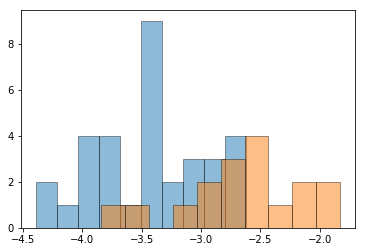

In [50]:
values_cen = noise_map(data_cen,mag_cen,x_data_cen,y_data_cen,False)
values_hal = noise_map(data_hal,mag_hal,x_data_hal,y_data_hal,False)

In [44]:
values_cen

[array([1.81970086e+16, 1.54596622e+16, 1.31340904e+16, 1.11583505e+16,
        9.47981801e+15, 8.05378441e+15, 6.84226673e+15, 5.81299568e+15,
        4.93855620e+15, 4.19565722e+15]),
 array([-4.39 , -4.213, -4.036, -3.859, -3.682, -3.505, -3.328, -3.151,
        -2.974, -2.797]),
 array([-4.39 , -4.213, -4.036, -3.859, -3.682, -3.505, -3.328, -3.151,
        -2.974, -2.797])]

In [49]:
y_data_hal

453